# Carrots Regression Model with SARIMA
By Menard Gymer V. Rivera

## Load the Dataset

In [1]:
import pandas as pd

In [2]:
Tilapia_UN = pd.read_excel('./data/carrots_UN.xlsx')

In [3]:
Tilapia_DA = pd.read_excel('./data/carrots_DA.xlsx')

In [4]:
Tilapia_UN

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,166,Carrots - Retail,5,KG,1,2008,53.17
1,166,Carrots - Retail,5,KG,1,2008,52.72
2,166,Carrots - Retail,5,KG,1,2008,40.52
3,166,Carrots - Retail,5,KG,1,2008,52.28
4,166,Carrots - Retail,5,KG,1,2008,56.70
...,...,...,...,...,...,...,...
2632,166,Carrots - Retail,5,KG,6,2021,103.75
2633,166,Carrots - Retail,5,KG,6,2021,88.75
2634,166,Carrots - Retail,5,KG,6,2021,91.56
2635,166,Carrots - Retail,5,KG,6,2021,123.13


In [5]:
Tilapia_DA.head()

,cm_id,cm_name,um_id,um_name,mp_month,mp_year,mp_price
0,NaN,Carrots - Retail,NaN,KG,1,2022,81.57
1,NaN,Carrots - Retail,NaN,KG,2,2022,85.68
2,NaN,Carrots - Retail,NaN,KG,3,2022,99.84
3,NaN,Carrots - Retail,NaN,KG,4,2022,86.25
4,NaN,Carrots - Retail,NaN,KG,5,2022,84.70


## Extract Necessary Columns (Date and Price)

### UN World Food Programme

In [6]:
Tilapia_UN['date'] = pd.to_datetime(
    Tilapia_UN.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [7]:
Tilapia_UN = Tilapia_UN.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [8]:
Tilapia_UN.head()

,mp_price,date
0,53.17,2008-01-15
1,52.72,2008-01-15
2,40.52,2008-01-15
3,52.28,2008-01-15
4,56.70,2008-01-15


### DA Bantay Presyo

In [9]:
Tilapia_DA['date'] = pd.to_datetime(
    Tilapia_DA.rename(columns={'mp_year': 'year', 'mp_month': 'month'})[['year', 'month']].assign(day=15)
)

In [10]:
Tilapia_DA = Tilapia_DA.drop(columns=['cm_id', 'cm_name', 'um_id', 'um_name', 'mp_month', 'mp_year'])

In [11]:
Tilapia_DA.head()

,mp_price,date
0,81.57,2022-01-15
1,85.68,2022-02-15
2,99.84,2022-03-15
3,86.25,2022-04-15
4,84.70,2022-05-15


In [12]:
import matplotlib.pyplot as plt

In [13]:
Tilapia = pd.concat([Tilapia_DA, Tilapia_UN])

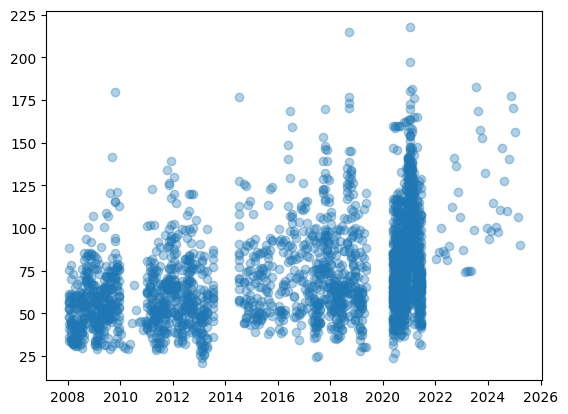

<Figure size 5000x600 with 0 Axes>

In [14]:
plt.scatter(Tilapia['date'], Tilapia['mp_price'], alpha=0.35)
plt.figure(figsize=(50, 6))
plt.show()

In [15]:
from datetime import datetime

In [16]:
# Set Date as the Inex
Tilapia = Tilapia.set_index('date')

In [17]:
# Aggregate samples to mean
Tilapia = Tilapia.resample('MS').mean()

In [18]:
Tilapia['mp_price'] = Tilapia['mp_price'].interpolate(method='linear')

In [19]:
start_date = datetime(2020,1,1)
end_date = datetime(2026,1,1)
lim_tilapia = Tilapia[start_date:end_date]

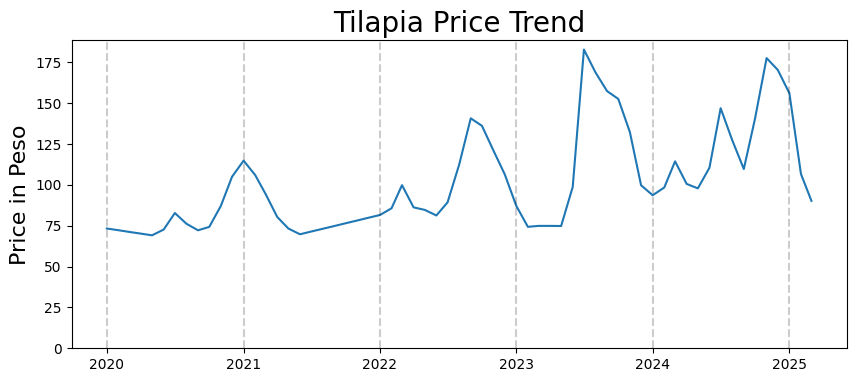

In [20]:
plt.figure(figsize=(10,4))
plt.plot(lim_tilapia)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
plt.ylim(bottom=0)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Remove the trend

In [21]:
first_diff = lim_tilapia.diff()[1:]

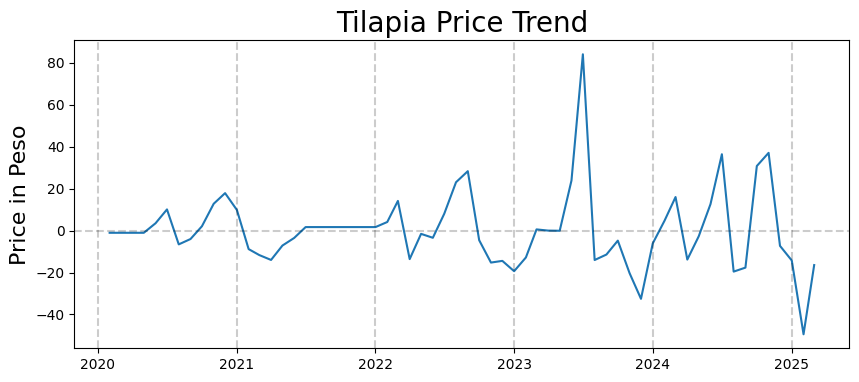

In [22]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

## ACF

In [23]:
from statsmodels.tsa.stattools import acf, pacf

<BarContainer object of 18 artists>

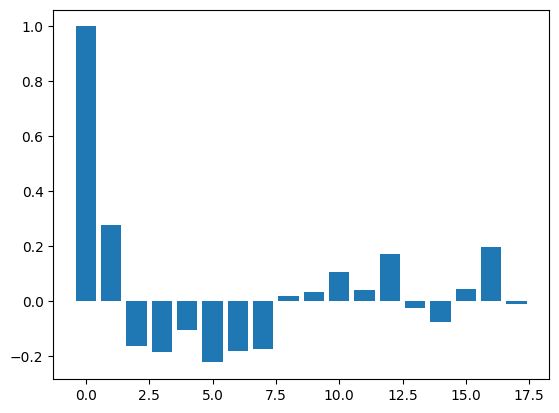

In [24]:
acf_vals = acf(first_diff)
num_lags = 18
plt.bar(range(num_lags), acf_vals[:num_lags])

### Based on ACF, we should start with a seasonal MA process

## PACF

<BarContainer object of 18 artists>

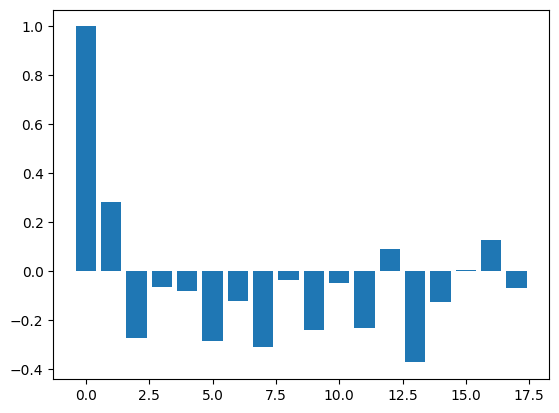

In [25]:
pacf_vals = pacf(first_diff)
num_lags = 18
plt.bar(range(num_lags), pacf_vals[:num_lags])

### Based on PACF, we should start with a seasonal AR process

## Get training and testing sets

In [26]:
from datetime import timedelta

In [27]:
train_end = datetime(2024,9,1)
test_end = datetime(2025,3,1)

train_data = lim_tilapia[:train_end]
test_data = lim_tilapia[train_end + timedelta(days=1):test_end]

In [28]:
Tilapia.describe()

,mp_price
count,207.000000
mean,76.434623
std,26.868015
min,29.000000
25%,60.483529
50%,71.458739
75%,83.201127
max,182.830000


## Fit the SARIMA Model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [30]:
my_order = (0,1,0)
my_seasonal_order = (1, 0, 1, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [31]:
from time import time

In [32]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

Model Fitting Time: 0.8339095115661621


In [33]:
#summary of the model
print(model_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             mp_price   No. Observations:                   57
Model:             SARIMAX(0, 1, 0)x(1, 0, [1], 12)   Log Likelihood                -234.904
Date:                              Thu, 22 May 2025   AIC                            475.807
Time:                                      19:41:07   BIC                            481.883
Sample:                                  01-01-2020   HQIC                           478.163
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.1673      0.893     -0.187      0.851      -1.917       1.582
ma.S.L12       0.52

In [34]:
print(type(test_data))
print(test_data.columns)
print(test_data.head())

<class 'pandas.core.frame.DataFrame'>
Index(['mp_price'], dtype='object')
            mp_price
date                
2024-10-01    140.53
2024-11-01    177.62
2024-12-01    170.35
2025-01-01    156.11
2025-02-01    106.67


In [35]:
# Assuming test_data is a DataFrame with a single column named "mp_price"
test_series = test_data['mp_price']

In [36]:
#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [37]:
predictions

date
2024-10-01    108.935460
2024-11-01    104.157340
2024-12-01     94.673532
2025-01-01     95.821585
2025-02-01    100.694703
2025-03-01    108.204660
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
residuals

date
2024-10-01    31.594540
2024-11-01    73.462660
2024-12-01    75.676468
2025-01-01    60.288415
2025-02-01     5.975297
2025-03-01   -17.964660
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

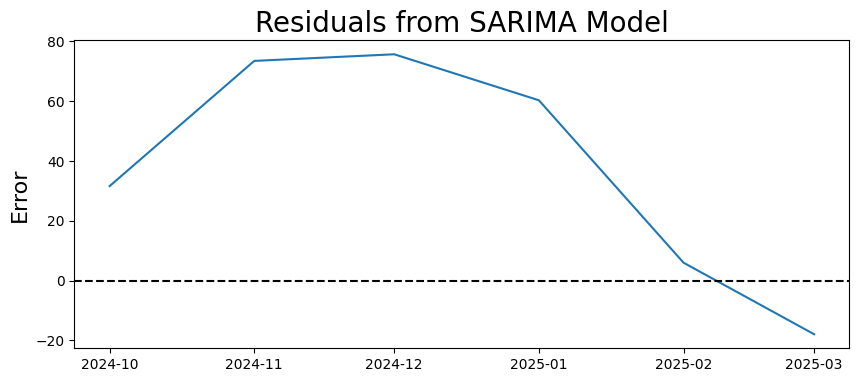

In [39]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

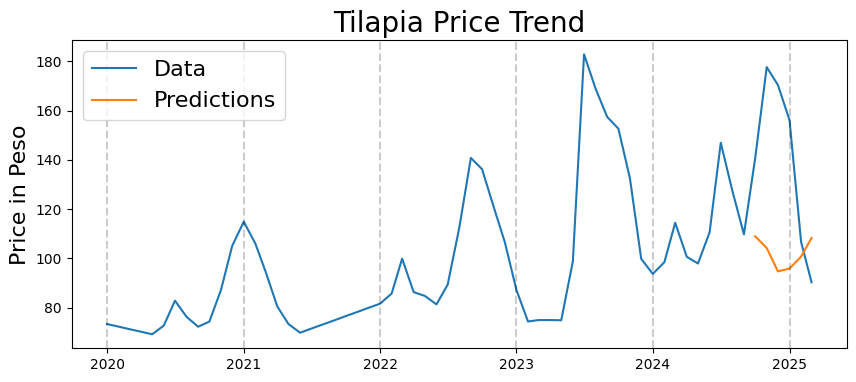

In [40]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

## Using the Rolling Forecast Origin

In [41]:
rolling_predictions = test_series.copy()
for train_end in test_series.index:
    train_data = lim_tilapia[:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

/tmp/ipykernel_28036/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_28036/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_28036/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_28036/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  rolling_predictions[train_end] = pred
/tmp/ipykernel_28036/2554385675.py:8: FutureWarning: Calling float on a single element Series is deprecated and will

In [42]:
rolling_residuals = test_series - rolling_predictions

Text(0, 0.5, 'Error')

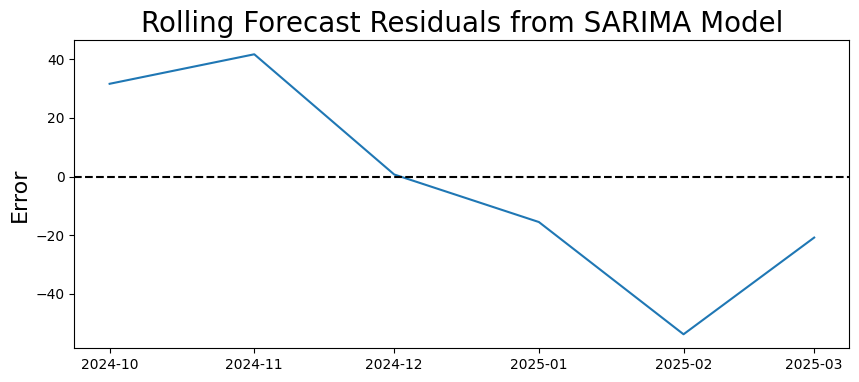

In [43]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

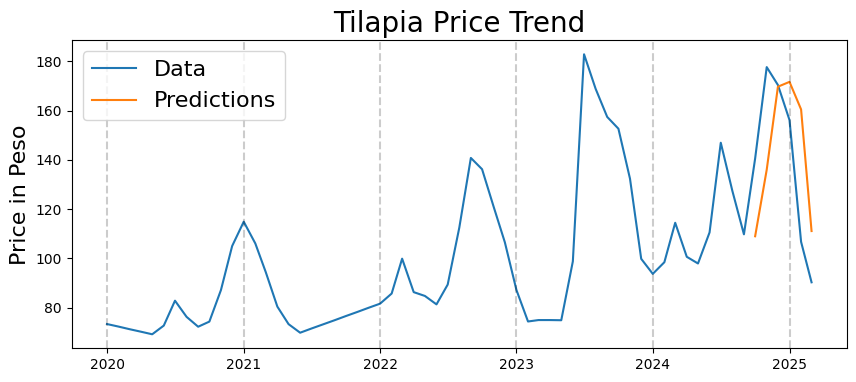

In [44]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(rolling_predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [45]:
import numpy as np

In [46]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test_series)),4))

Mean Absolute Percent Error: 0.2162


In [47]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 32.39932222676829


## Future Predictions (2025)

In [48]:
#get the predictions and residuals
predictions = model_fit.forecast(12)
# predictions = pd.Series(predictions, index=test_data.index)
residuals = test_series - predictions

In [49]:
predictions

2025-03-01    111.051369
2025-04-01    107.384258
2025-05-01    106.728557
2025-06-01    107.927022
2025-07-01    110.543847
2025-08-01    107.342673
2025-09-01    104.547058
2025-10-01    112.462786
2025-11-01    122.924794
2025-12-01    123.355642
2026-01-01    119.820906
2026-02-01    106.776317
Freq: MS, Name: predicted_mean, dtype: float64

In [50]:
residuals

2024-10-01          NaN
2024-11-01          NaN
2024-12-01          NaN
2025-01-01          NaN
2025-02-01          NaN
2025-03-01   -20.811369
2025-04-01          NaN
2025-05-01          NaN
2025-06-01          NaN
2025-07-01          NaN
2025-08-01          NaN
2025-09-01          NaN
2025-10-01          NaN
2025-11-01          NaN
2025-12-01          NaN
2026-01-01          NaN
2026-02-01          NaN
Freq: MS, dtype: float64

Text(0, 0.5, 'Error')

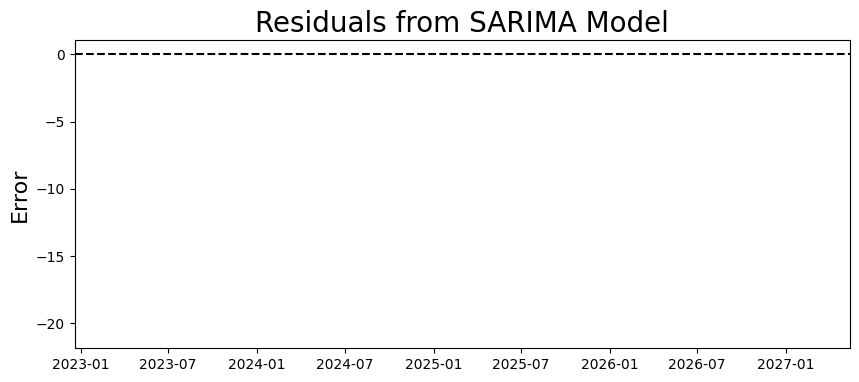

In [51]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

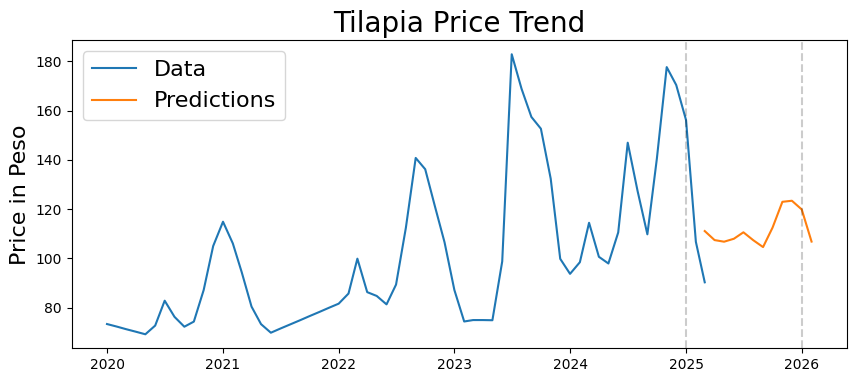

In [52]:
plt.figure(figsize=(10,4))

plt.plot(lim_tilapia)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=16)

plt.title('Tilapia Price Trend', fontsize=20)
plt.ylabel('Price in Peso', fontsize=16)
for year in range(2025,2027):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [53]:
# Tilapia 100g
# Protein = 19g
protein = 0.94*10
# Carbohydrates = 0g
carbs = 10.3*10
# Fats = 2.48 g
fats = 0.35*10
# Fiber 0g
fiber = 3.1*10

In [54]:
protein_projection = protein / predictions

Text(0, 0.5, 'Protein in Grams')

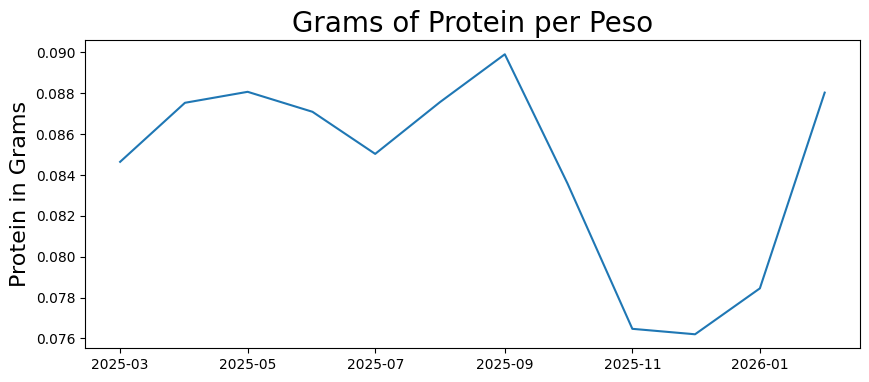

In [55]:
plt.figure(figsize=(10,4))

plt.plot(protein_projection)

plt.title('Grams of Protein per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [56]:
carbs_projection = carbs / predictions

Text(0, 0.5, 'Protein in Grams')

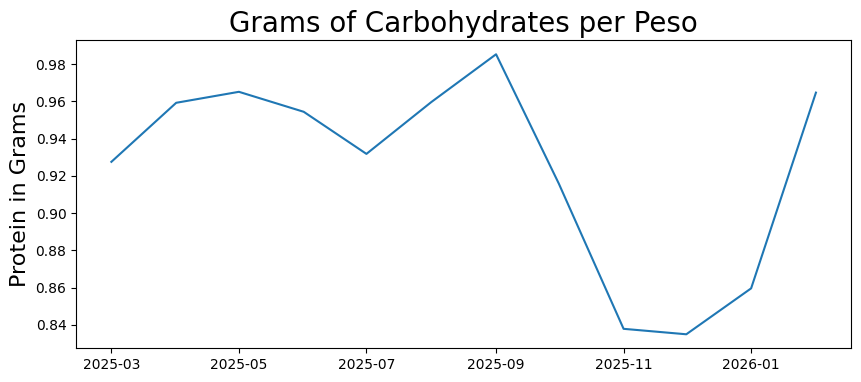

In [57]:
plt.figure(figsize=(10,4))

plt.plot(carbs_projection)

plt.title('Grams of Carbohydrates per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [58]:
fats_projection = fats / predictions

Text(0, 0.5, 'Protein in Grams')

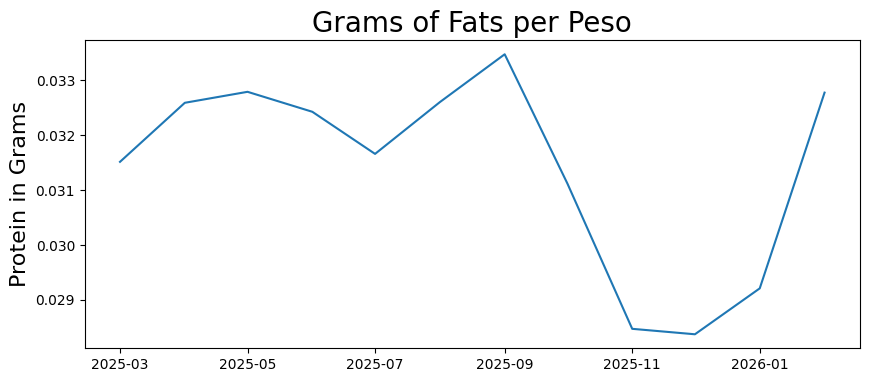

In [59]:
plt.figure(figsize=(10,4))

plt.plot(fats_projection)

plt.title('Grams of Fats per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [60]:
fiber_projection = fiber / predictions

Text(0, 0.5, 'Protein in Grams')

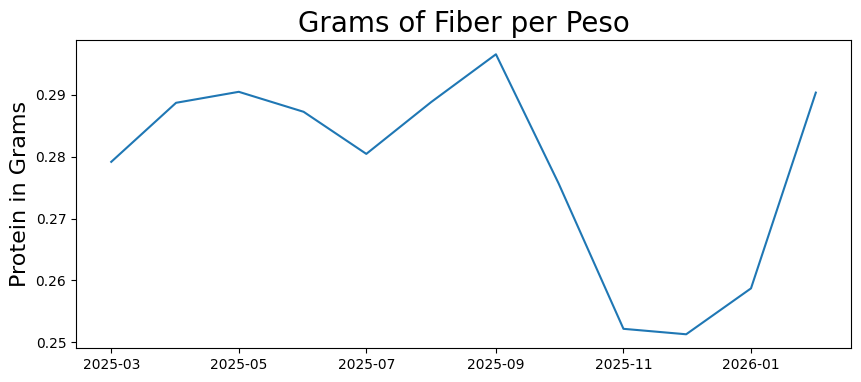

In [61]:
plt.figure(figsize=(10,4))

plt.plot(fiber_projection)

plt.title('Grams of Fiber per Peso', fontsize=20)
plt.ylabel('Protein in Grams', fontsize=16)

In [62]:
protein_projection.to_csv('./protein.csv', index=True)
carbs_projection.to_csv('./carbs.csv', index=True)
fats_projection.to_csv('./fats.csv', index=True)
fiber_projection.to_csv('./fiber.csv', index=True)